In [6]:
import numpy as np
import pandas as pd
import random as rd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [7]:
def get_accuracy(Y_true, Y_pred):

    assert len(Y_true ) == len(Y_pred)
    return np.sum(Y_true == Y_pred)/len(Y_true)

In [8]:
data = np.genfromtxt('Dataset/metastatic_pgm.csv', delimiter=',', skip_header=0)

print(f'Shape of the data {data.shape}')

Shape of the data (1001, 5)


In [9]:
# Verifying the presence of missing values
print(f'Number of missing values: {np.isnan(data).sum()}')

Number of missing values: 5


In [10]:
# Removing rows with missing values
data=data[~np.isnan(data).any(axis=1)]

print(f'Shape of processed dataset {data.shape}')

Shape of processed dataset (1000, 5)


In [11]:
# Verifying missing values in the processed data
print(f'Number of missing values after processing: {np.isnan(data).sum()}')

Number of missing values after processing: 0


In [12]:
#Defind fearure and target
X = np.delete(data,3,axis=1)
y = data[:,3]

X_tr, X_ts, y_tr, y_ts = train_test_split(X,y,test_size=0.10, random_state=102)
print(f'Shape of Xtrain: {X_tr.shape}')
print(f'Shape of ytrain: {y_tr.shape}')
print(f'Shape of Xtest : {X_ts.shape}')
print(f'Shape of ytest : {y_ts.shape}')

Shape of Xtrain: (900, 4)
Shape of ytrain: (900,)
Shape of Xtest : (100, 4)
Shape of ytest : (100,)


In [13]:
print(X_tr)

[[0. 0. 0. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 ...
 [1. 0. 1. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


### Sigmoid Function
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

In [14]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [10]:
# computing cost and gradient descent function
def compute_cost(X,y,w):

    N = len(y)
    z = sigmoid(X.dot(w))
    epsilon = 1e-5
    cost = (1/N)*(((-y).T @ np.log(z + epsilon)) - ((1-y).T @ np.log(1-z + epsilon)))
    return cost

def gradient_descent(X, y, w, n_iters, alpha=0.01, threshold=1e-07):

    N = len(y)
    log_j = []
    j_last = np.Inf
    for _ in range(n_iters):
        y_pred = sigmoid(np.dot(X, w))
        gradient = np.dot(X.T, (y_pred - y)) / N
        w -= alpha * gradient
        cost = compute_cost(X, y, w)
        log_j.append(cost)
        if abs(j_last - cost) < threshold:
            break
        j_last = cost
    return w, log_j

# Defining the logistic regression training function
def train_logreg(X_tr, y_tr, n_iters=1500):
    """
    train_logreg
    Input: X_tr - Training input attributes
           y_tr - Training target labels
           n_iters - number of iterations (default: 1500)
    Output: w_star - trained model weights
            log_j - cost history
    """
    N_tr, d_tr = X_tr.shape

    X_tr_b = np.hstack((X_tr, np.ones((N_tr, 1))))
    w_init = np.zeros(d_tr + 1)

    initial_cost = compute_cost(X_tr_b, y_tr, w_init)
    print("Initial J(w_init, D_tr) is: ", initial_cost, "\n")

    w_star, log_j = gradient_descent(X_tr_b, y_tr, w_init, n_iters)

    print("w*: \n", w_star, "\n")
    print("J(w*, D_tr): ", log_j[-1])

    return w_star, log_j


In [11]:
def predict_logreg(X, w):
    """
    predict_logreg
    Input: X - Input attributes to predict the target output
           w - Trained model weights
    Output: y_pred - predicted target labels {0, 1}
            y_prob - estimated conditional probability P(y=1|x)
    """
    X_b = np.hstack((X, np.ones((X.shape[0], 1))))
    y_prob = sigmoid(np.dot(X_b, w))
    y_pred = (y_prob >= 0.5).astype(int)
    return y_pred, y_prob

In [12]:
Model_logreg, log_j_logreg = train_logreg(X_tr, y_tr, 5000)

# Making prediction for the train and test sets
y_tr_pred, y_p= predict_logreg(X_tr, Model_logreg)
y_ts_pred,y_p = predict_logreg(X_ts, Model_logreg)

# Evaluating the accuracy of the model on both sets using the get accuracy function
accuracy_train = get_accuracy(y_tr,y_tr_pred)
accuracy_test = get_accuracy(y_ts,y_ts_pred)
print(f"Traning set accuracy: {accuracy_train}")
print(f"Testing set accuracy: {accuracy_test}")

Initial J(w_init, D_tr) is:  0.6931271807599432 

w*: 
 [ 0.70030582  1.02365066  2.4039436  -0.3746134  -1.81457868] 

J(w*, D_tr):  0.3592841554598162
Traning set accuracy: 0.8666666666666667
Testing set accuracy: 0.87


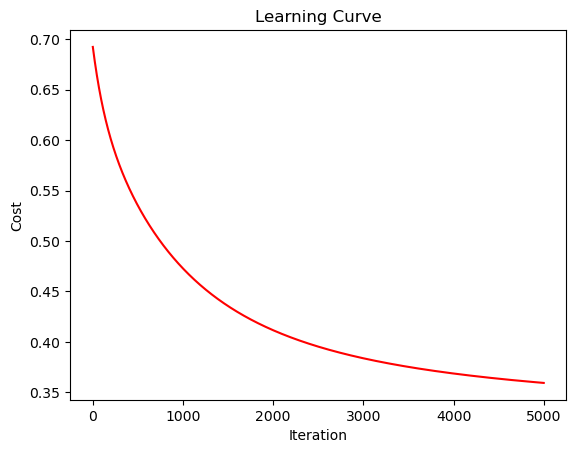

In [13]:
# Visualizing the learning curve
plt.plot(log_j_logreg, c='red')
plt.title('Learning Curve')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

## Decision tree

#### Entrophy formula 
Complete the `compute_entropy()` function below to:
* Compute $p_1$, which is the fraction of examples that are edible (i.e. have value = `1` in `y`)
* The entropy is then calculated as 

$$H(p_1) = -p_1 \text{log}_2(p_1) - (1- p_1) \text{log}_2(1- p_1)$$
* Note 
    * The log is calculated with base $2$
    * For implementation purposes, $0\text{log}_2(0) = 0$. That is, if `p_1 = 0` or `p_1 = 1`, set the entropy to `0`
    * Make sure to check that the data at a node is not empty (i.e. `len(y) != 0`). Return `0` if it is

In [14]:
def compute_entropy(y):

    entropy = 0.0

    if len(y) != 0:
        p1 = p1 = len(y[y == 1]) / len(y) 
        if p1 != 0 and p1 != 1:
             entropy = -p1 * np.log2(p1) - (1 - p1) * np.log2(1 - p1)
        else:
             entropy = 0
      
    return entropy


In [15]:
print("enteropy:", compute_entropy(y_tr))

enteropy: 0.8599530497177521


In [16]:
def split_dataset(X, node_indices, feature):
    """
    Splits the data at the given node into
    left and right branches
    
    Args:
        X (ndarray):             Data matrix of shape(n_samples, n_features)
        node_indices (list):  List containing the active indices. I.e, the samples being considered at this step.
        feature (int):           Index of feature to split on
    
    Returns:
        left_indices (list): Indices with feature value == 1
        right_indices (list): Indices with feature value == 0
    """
    left_indices = []
    right_indices = []

    for i in node_indices:   
        if X[i][feature] == 1:
            left_indices.append(i)
        else:
            right_indices.append(i)
        
    return left_indices, right_indices

In [17]:
total_rows = 900
root_node_indices = np.arange(total_rows)

In [18]:
def compute_information_gain(X, y, node_indices, feature):
    """
    Compute the information of splitting the node on a given feature
    
    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.
   
    Returns:
        cost (float):        Cost computed
    
    """    
    #splite dataset
    left_indices, right_indices = split_dataset(X, node_indices, feature)

    X_node, y_node = X[node_indices], y[node_indices]
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[right_indices], y[right_indices]

    imformation_gain = 0

    node_entropy = compute_entropy(y_node)
    left_entropy = compute_entropy(y_left)
    right_entropy = compute_entropy(y_right)

    w_left = len(X_left) / len(X_node)
    w_right = len(X_right) / len(X_node)

    weighted_entropy = w_left * left_entropy + w_right * right_entropy

    #information gain
    informtion_gain = node_entropy - weighted_entropy

    return informtion_gain

In [19]:
info_gain0 = compute_information_gain(X_tr, y_tr,root_node_indices, feature=0)
print("Information Gain from splitting the root on Metatstatic cancer: ", info_gain0)
info_gain1 = compute_information_gain(X_tr, y_tr,root_node_indices, feature=1)
print("Information Gain from splitting the root on Brain tumour: ", info_gain1)
info_gain2 = compute_information_gain(X_tr, y_tr,root_node_indices, feature=2)
print("Information Gain from splitting the root on increase total serum celcium: ", info_gain2)
info_gain3 = compute_information_gain(X_tr, y_tr,root_node_indices, feature=3)
print("Information Gain from splitting the root on severe headchaches: ", info_gain3)

Information Gain from splitting the root on Metatstatic cancer:  0.11312702326852309
Information Gain from splitting the root on Brain tumour:  0.06542444352004118
Information Gain from splitting the root on increase total serum celcium:  0.32477346777164195
Information Gain from splitting the root on severe headchaches:  0.0001855079164423401


Splitting on "increase total serum celcium" (feature = 2) at the root node gives the maximum information gain. Therefore, it's the best feature to split on at the root node.

In [20]:
def get_best_split(X, y, node_indices):   
    """
    Returns the optimal feature and threshold value
    to split the node data 
    
    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.

    Returns:
        best_feature (int):     The index of the best feature to split
    """    
    
    num_features = X.shape[1]
    
    best_feature = -1
    
    max_info_gain=0
    for feature in range(num_features):
        info_gain = compute_information_gain(X, y, node_indices, feature)
        if info_gain > max_info_gain:
            max_info_gain = info_gain
            best_feature = feature
                       
    return best_feature

In [21]:
best_feature = get_best_split(X_tr, y_tr, root_node_indices)
print("Best feature to split on: %d" % best_feature)

Best feature to split on: 2


In [22]:
tree = []

def build_tree_recursive(X, y, node_indices, branch_name, max_depth, current_depth):
    """
    Build a tree using the recursive algorithm that split the dataset into 2 subgroups at each node.
    This function just prints the tree.
    
    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.
        branch_name (string):   Name of the branch. ['Root', 'Left', 'Right']
        max_depth (int):        Max depth of the resulting tree. 
        current_depth (int):    Current depth. Parameter used during recursive call.
   
    """ 

    # Maximum depth reached - stop splitting
    if current_depth == max_depth:
        formatting = " "*current_depth + "-"*current_depth
        print(formatting, "%s leaf node with indices" % branch_name, node_indices)
        return
   
    # Otherwise, get best split and split the data
    # Get the best feature and threshold at this node
    best_feature = get_best_split(X, y, node_indices) 
    tree.append((current_depth, branch_name, best_feature, node_indices))
    
    formatting = "-"*current_depth
    print("%s Depth %d, %s: Split on feature: %d" % (formatting, current_depth, branch_name, best_feature))
    
    # Split the dataset at the best feature
    left_indices, right_indices = split_dataset(X, node_indices, best_feature)
    
    # continue splitting the left and the right child. Increment current depth
    build_tree_recursive(X, y, left_indices, "Left", max_depth, current_depth+1)
    build_tree_recursive(X, y, right_indices, "Right", max_depth, current_depth+1)


In [23]:
build_tree_recursive(X_tr, y_tr, root_node_indices, "Root", max_depth=4, current_depth=0)

 Depth 0, Root: Split on feature: 2
- Depth 1, Left: Split on feature: 3
-- Depth 2, Left: Split on feature: 1
--- Depth 3, Left: Split on feature: 0
    ---- Left leaf node with indices [1, 10, 28, 118, 119, 145, 160, 226, 244, 271, 291, 303, 306, 318, 429, 490, 528, 540, 562, 625, 637, 652, 782, 821]
    ---- Right leaf node with indices [52, 221]
--- Depth 3, Right: Split on feature: 0
    ---- Left leaf node with indices [9, 15, 35, 38, 45, 55, 57, 66, 69, 94, 176, 177, 194, 195, 197, 199, 207, 218, 277, 296, 304, 316, 321, 325, 338, 352, 369, 372, 383, 388, 393, 394, 399, 401, 411, 422, 440, 467, 470, 475, 505, 539, 550, 563, 570, 603, 608, 617, 619, 693, 700, 701, 711, 724, 740, 743, 751, 759, 776, 781, 806, 844, 849, 854, 879, 888, 893, 897]
    ---- Right leaf node with indices [2, 13, 36, 44, 53, 81, 86, 96, 102, 106, 113, 117, 159, 222, 228, 230, 233, 243, 245, 252, 260, 263, 286, 289, 297, 309, 319, 340, 341, 345, 351, 353, 417, 435, 450, 482, 487, 496, 508, 536, 537, 571, 5

### Artificialneura  network model 

In [3]:
# Fully connected neural network with one hidden layer
class FFNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FFNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First hidden layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Output layer

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return torch.sigmoid(out).squeeze(1)  # Apply sigmoid to constrain outputs to 0-1
learning_rate = 0.01
model = FFNet(4,32,2)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

In [15]:
# Training loop
num_epochs = 3000

for epoch in range(num_epochs):
    for X_batch, y_batch in X_tr:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred.view(-1),y_batch)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 100 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        test_pred = model(X_batch)
        pre = (test_pred > 0.5).float()
        accuracy = (pre == y_batch).float().mean()

print(f'Accuracy on test set: {accuracy.item():.4f}')

ValueError: too many values to unpack (expected 2)